In [10]:
!ln -s /data /habitat-api/data
!ln -s /data ./data

In [1]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import habitat
from habitat.core.utils import try_cv2_import

from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import images_to_video

In [2]:
cv2 = try_cv2_import()

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()

In [3]:
def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        info["top_down_map"]["map"], info["top_down_map"]["fog_of_war_mask"]
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

In [4]:
IMAGE_DIR = os.path.join("examples", "images")
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR)

In [5]:
config = habitat.get_config(config_paths="../habitat-api/configs/tasks/pointnav.yaml")
config.defrost()
config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.SIMULATOR.SCENE = 'data/scene_datasets/gibson/Aldrich.glb'
config.freeze()

In [7]:
env = SimpleRLEnv(config=config)
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE
follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)
mode = "geodesic_path"
follower.mode = mode

2020-02-10 11:32:24,249 Initializing dataset PointNav-v1
2020-02-10 11:32:24,648 initializing sim Sim-v0
I0210 11:32:26.039341 4633 simulator.py:142] Loaded navmesh data/scene_datasets/habitat-test-scenes/skokloster-castle.navmesh
2020-02-10 11:32:26,043 Initializing task Nav-v0


In [8]:
env.reset();

In [9]:
episode = 0
dirname = os.path.join(
            IMAGE_DIR, "shortest_path_example", mode, "%02d" % episode
        )
if os.path.exists(dirname):
    shutil.rmtree(dirname)
os.makedirs(dirname)
print("Agent stepping around inside environment.")

Agent stepping around inside environment.


In [10]:
images = []

In [162]:
best_action = follower.get_next_action(
                env.habitat_env.current_episode.goals[0].position
            )
observations, reward, done, info = env.step(best_action)
im = observations["rgb"]
top_down_map = draw_top_down_map(info, observations["heading"][0], im.shape[0])
output_im = np.concatenate((im, top_down_map), axis=1)
images.append(output_im)

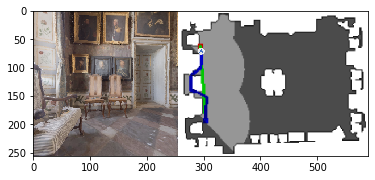

In [163]:
plt.imshow(output_im)

In [14]:
env.habitat_env.current_episode.goals[0].position

[3.9171383380889893, 0.17669875919818878, 0.1997380256652832]

In [124]:
env.habitat_env._current_episode.__dict__

{'episode_id': '4979',
 'scene_id': 'data/scene_datasets/habitat-test-scenes/van-gogh-room.glb',
 'start_position': [1.3296443223953247,
  0.17669875919818878,
  0.2641213536262512],
 'start_rotation': [0, 0.986842993376632, 0, -0.16168149684935734],
 'info': {'geodesic_distance': 1.7974324226379395, 'difficulty': 'easy'},
 'goals': [NavigationGoal(position=[2.790069580078125, 0.17669875919818878, -0.6188956499099731], radius=None)],
 'start_room': None,
 'shortest_paths': None}